Epoch 100, Loss: 1.4966919422149658
Coefficients for mean:
a0: 0.43820422887802124
a1: 2.848421573638916
a2: -0.16256460547447205
Coefficients for std:
a0: 0.019450336694717407
a1: -0.0629027858376503
a2: -0.021300677210092545


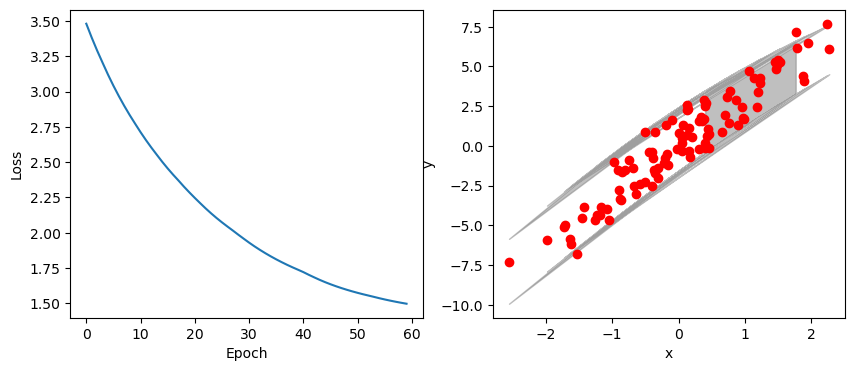

In [20]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 生成一些模拟数据
np.random.seed(0)
x = np.random.normal(0, 1, size=(100, 1))
y = 3 * x + np.random.normal(0, 1, size=(100, 1))
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# 定义模型
class PolynomialRegressor(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegressor, self).__init__()
        self.degree = degree
        self.coefficients_mean = nn.Parameter(torch.randn(degree + 1))  # 预测均值的系数
        self.coefficients_std = nn.Parameter(torch.randn(degree + 1))  # 预测标准差的系数

    def forward(self, x):
        mean = sum(self.coefficients_mean[i] * x.pow(i) for i in range(self.degree + 1))
        std = torch.exp(sum(self.coefficients_std[i] * x.pow(i) for i in range(self.degree + 1)))  # 确保标准差为正
        return mean, std

# 训练模型
model = PolynomialRegressor(degree=2)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


# 训练模型并记录每个epoch的损失
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    mean, std = model(x_tensor)
    # print(x_tensor)
    # print(y_tensor)
    loss = criterion(mean, y_tensor) + criterion(std, torch.abs(y_tensor - mean))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# 打印模型的系数
print("Coefficients for mean:")
for i, coef in enumerate(model.coefficients_mean):
    print(f"a{i}: {coef.item()}")

print("Coefficients for std:")
for i, coef in enumerate(model.coefficients_std):
    print(f"a{i}: {coef.item()}")


# 绘制损失随epoch变化的图像
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses[40:])
plt.xlabel('Epoch')
plt.ylabel('Loss')


# 生成预测区间
with torch.no_grad():
    mean, std = model(x_tensor)
    lower_bound = mean - 1.96 * std
    upper_bound = mean + 1.96 * std

# 绘制数据预测的区间和真实值的图像
plt.subplot(1, 2, 2)
plt.fill_between(x_tensor.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.5)  # 预测区间
plt.scatter(x, y, color='red')  # 真实值
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from power_plant_dataset import PowerPlantDataset
import os


dataset = PowerPlantDataset(csv_file='fdcl/split/df_gf.csv')
train_size = int(0.99 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=1000, shuffle=True, num_workers=2)

# 定义模型
class PolynomialRegressor(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegressor, self).__init__()
        self.degree = degree
        self.coefficients_mean = nn.Parameter(torch.randn(degree + 1))  # 预测均值的系数
        self.coefficients_std = nn.Parameter(torch.randn(degree + 1))  # 预测标准差的系数

    def forward(self, x):
        mean = sum(self.coefficients_mean[i] * x.pow(i) for i in range(self.degree + 1))
        std = torch.exp(sum(self.coefficients_std[i] * x.pow(i) for i in range(self.degree + 1)))  # 确保标准差为正
        return mean, std

# 训练模型
model = PolynomialRegressor(degree=3)
# 检查模型文件是否存在
if os.path.exists('gf.pth'):
    # 如果模型文件存在，加载模型参数
    model.load_state_dict(torch.load('gf.pth'))
else:
    print("Model file does not exist.")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


def custom_loss(mean, std, labels):
    lower_bound = mean - std
    upper_bound = mean + std

    # 计算 labels 和边界之间的距离
    dist_to_lower_bound = lower_bound - labels
    dist_to_upper_bound = labels - upper_bound

    # 计算损失
    loss = torch.where(labels < lower_bound, dist_to_lower_bound, 0.0)
    loss += torch.where(labels > upper_bound, dist_to_upper_bound, 0.0)

    return loss.mean()
# 训练模型并记录每个epoch的损失
losses = []
for epoch in tqdm(range(200)):
    for i, data in enumerate(train_dataloader):
        # 清零梯度
        optimizer.zero_grad()

        # 前向 + 后向 + 优化
        
        inputs, labels = data
        # print(inputs)
        mean, std = model(inputs)
        # print(labels)
        # loss = 0.8 * criterion(mean, labels) + 0.2 * criterion(std, torch.abs(labels - mean))
        loss = 0.8 * criterion(mean, labels) + 0.2 * custom_loss(mean, std, labels)

        #让模型不仅能预测出均值，还预测出预测值的不确定性（通过标准差表示）
        loss.backward()
        optimizer.step()
        # print(loss)
        # 记录损失
        losses.append(loss.item())

        
    if (epoch) % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        
        # 生成预测区间

        
# 打印模型的系数
print("Coefficients for mean:")
for i, coef in enumerate(model.coefficients_mean):
    print(f"a{i}: {coef.item()}")

print("Coefficients for std:")
for i, coef in enumerate(model.coefficients_std):
    print(f"a{i}: {coef.item()}")
    
# 绘制损失随epoch变化的图像
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses[50:])
plt.xlabel('Batch')
plt.ylabel('Loss')



# 测试模型并记录每个批次的损失
valid_losses = []
model.eval()  # 切换模型到评估模式
with torch.no_grad():  # 关闭梯度计算
    for i, data in enumerate(valid_dataloader):
        # 前向计算
        inputs, labels = data
        # print(inputs)
        mean, std = model(inputs)

        loss = criterion(mean, labels) + criterion(std, torch.abs(labels - mean))

        # 记录损失
        valid_losses.append(loss.item())

# 计算平均损失
avg_valid_loss = np.mean(valid_losses)
print(f'Average validation loss: {avg_valid_loss}')
# 保存模型参数
torch.save(model.state_dict(), 'gf_model3.pth')



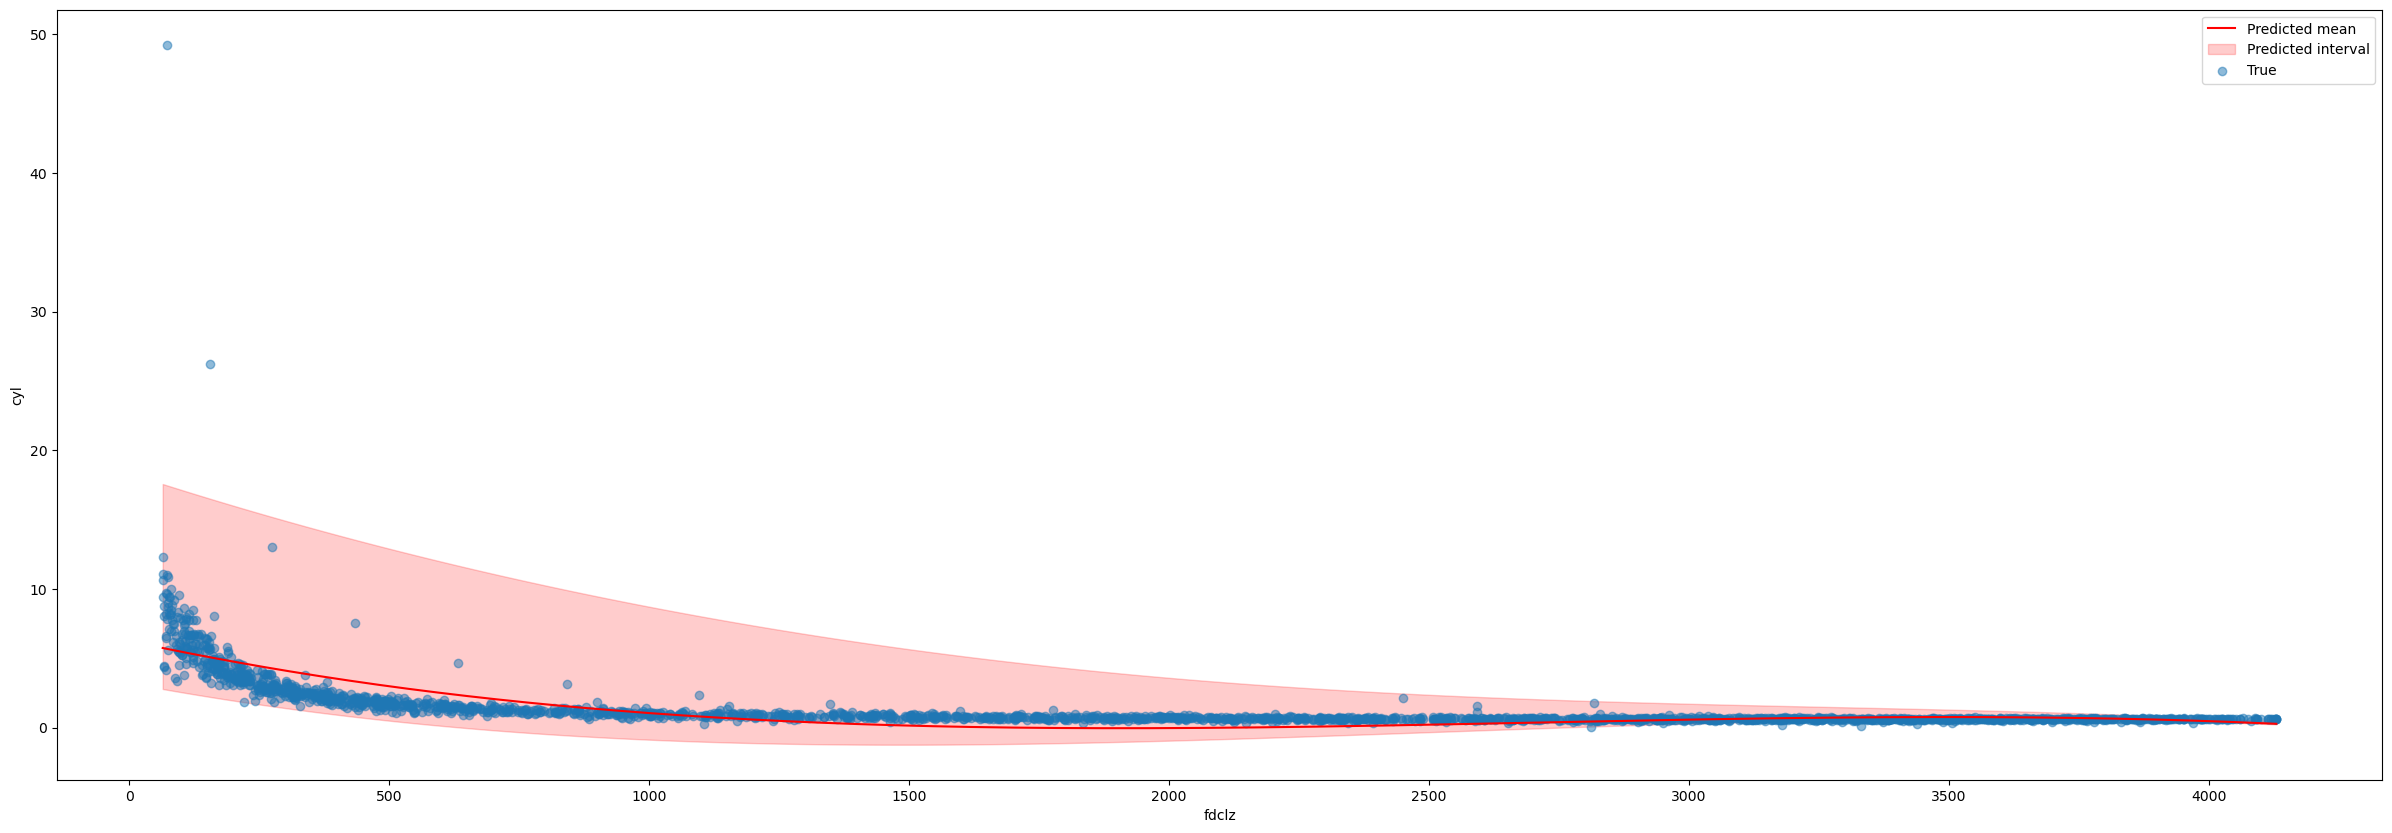

In [3]:
# 保存模型参数
torch.save(model.state_dict(), 'gf_okkkk.pth')
# 用于存储dataset值的列表
features_list = []
real_outputs = []

# 遍历数据集
for i in range(len(dataset)):
    # 获取特征和标签
    features, label = dataset[i]

    # 将特征和标签添加到dataset值列表
    features_list.append(features.item())
    real_outputs.append(label.item())

# 将真实值逆向标准化
real_features_list = dataset.inverse_transform_features(np.array(features_list).reshape(-1, 1))
real_outputs = dataset.inverse_transform_labels(np.array(real_outputs).reshape(-1, 1))

# 根据特征值对真实值进行排序
sorted_indices = np.argsort(real_features_list, axis=0).flatten()
real_features_list = real_features_list[sorted_indices]
real_outputs = real_outputs[sorted_indices]

# 创建一个新的特征数组，用于模型预测
new_features = np.linspace(min(features_list), max(features_list), 500).reshape(-1, 1)

# 将numpy数组转换为PyTorch张量
new_features_torch = torch.from_numpy(new_features).float()

# 使用模型进行预测
mean, std = model(new_features_torch)

# 将预测值逆向标准化
low = dataset.inverse_transform_labels((mean-1*std).detach().numpy())
upper = dataset.inverse_transform_labels((mean+4*std).detach().numpy())
mean = dataset.inverse_transform_labels((mean).detach().numpy())

# 逆向标准化新的特征数组，用于绘图
new_features_real = dataset.inverse_transform_features(new_features)

plt.figure(figsize=(30, 10))

# 绘制预测的均值和区间
plt.plot(new_features_real, mean, 'r-', label='Predicted mean')
plt.fill_between(new_features_real.flatten(), low.flatten(), upper.flatten(), color='r', alpha=0.2, label='Predicted interval')

# 绘制真实值
plt.scatter(real_features_list, real_outputs, label='True', alpha=0.5)

plt.xlabel('fdclz')
plt.ylabel('cyl')
plt.legend()
plt.show()
